In [1]:
!pip install -q transformers datasets evaluate accelerate

import os, time, json
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

os.makedirs("results", exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
⚙️  Running in WANDB offline mode


##1. Load dataset

In [2]:
ds = load_dataset("ag_news")

# train
split   = ds["train"].train_test_split(
    test_size=0.1,
    seed=42,
    stratify_by_column="label"
)
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = ds["test"]

print(train_ds)
print(val_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 108000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 12000
})


##

In [3]:
_df = pd.DataFrame({"text": train_ds["text"], "label": train_ds["label"]})
_sub = _df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(n=5000, random_state=42)
)
train_small = Dataset.from_pandas(_sub.reset_index(drop=True), preserve_index=False)

print(train_small)

Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})


/tmp/ipython-input-515833324.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _sub = _df.groupby("label", group_keys=False).apply(


##2. DistilBERT v1（max_length=128, 200 steps）

In [4]:
model_name = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def preprocess(batch):
    return tok(batch["text"], truncation=True, padding=False, max_length=128)

enc_train = (
    train_small
    .map(preprocess, batched=True)
    .rename_column("label", "labels")
    .with_format("torch")
)

enc_val = (
    val_ds
    .map(preprocess, batched=True)
    .rename_column("label", "labels")
    .with_format("torch")
)

collator = DataCollatorWithPadding(tok)

enc_train, enc_val

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 20000
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 12000
 }))

In [5]:
# DistilBERT classfication model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4
)

for p in model.base_model.parameters():
    p.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params       = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params:,} / {all_params:,}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 593,668 / 66,956,548


In [6]:
#Accuracy + Macro-F1
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

In [7]:
args = TrainingArguments(
    output_dir="out_distilbert_head",
    max_steps=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    do_eval=False,
    logging_steps=50,
    save_steps=10_000_000,
    seed=42,
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [8]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=enc_train,
    eval_dataset=enc_val,
    data_collator=collator,
    compute_metrics=compute_metrics,
    tokenizer=None,
)

t0 = time.time()
trainer.train()
train_time_min = (time.time() - t0) / 60.0

metrics = trainer.evaluate(enc_val)
metrics = {k: float(v) for k, v in metrics.items()}
metrics["train_time_min"] = train_time_min

print("\n=== DistilBERT head-only on validation set ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

/tmp/ipython-input-462138066.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.302500
100,1.155000
150,1.051000
200,0.995500



=== DistilBERT head-only on validation set ===
eval_loss: 0.9788
eval_accuracy: 0.8472
eval_macro_f1: 0.8454
eval_runtime: 38.9226
eval_samples_per_second: 308.3040
eval_steps_per_second: 4.8300
epoch: 0.1600
train_time_min: 0.2410


<Figure size 520x440 with 0 Axes>

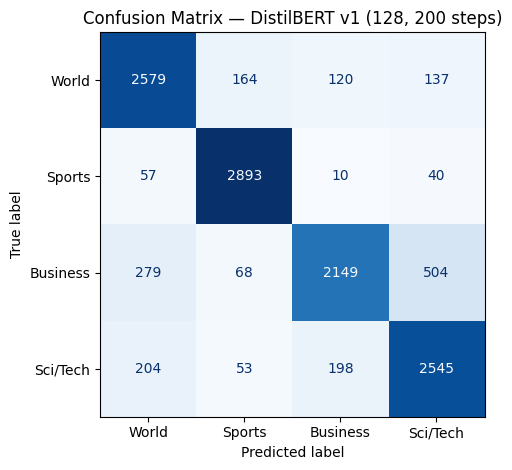

In [10]:
with open("results/distilbert_head_v1.json","w") as f:
    json.dump(metrics,f,indent=2)

pred_out = trainer.predict(enc_val)
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = logits.argmax(axis=-1)

labels4 = ["World","Sports","Business","Sci/Tech"]
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])

disp = ConfusionMatrixDisplay(cm, display_labels=labels4)
plt.figure(figsize=(5.2,4.4))
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — DistilBERT v1 (128, 200 steps)")
plt.tight_layout()
plt.savefig("results/confmat_distilbert_v1.png", dpi=300)
plt.show()

##Subword Length Analysis

In [11]:
sample_texts = train_ds["text"][:20000]
enc_no_trunc = tok(sample_texts, truncation=False, add_special_tokens=True)
sub_lens = np.array([len(ids) for ids in enc_no_trunc["input_ids"]])

p50  = float(np.percentile(sub_lens, 50))
p95  = float(np.percentile(sub_lens, 95))
t128 = float((sub_lens > 128).mean())
t256 = float((sub_lens > 256).mean())

print({"p50": p50, "p95": p95, "trunc@128": t128, "trunc@256": t256})

subword_stats = {
    "p50": p50,
    "p95": p95,
    "trunc@128": t128,
    "trunc@256": t256,
}
with open("results/subword_stats.json", "w") as f:
    json.dump(subword_stats, f, indent=2)

{'p50': 51.0, 'p95': 82.0, 'trunc@128': 0.00805, 'trunc@256': 0.00065}


##DistilBERT v2（max_length=192, 1000 steps）

In [13]:
model_name = "distilbert-base-uncased"
tok_192 = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def preprocess_192(batch):
    """
    v2 ：change max_length of DistilBERT from128to192。
    without padding
    """
    return tok_192(
        batch["text"],
        truncation=True,
        padding=False,
        max_length=192,
    )


enc_train_192 = train_small.map(preprocess_192, batched=True)
enc_val_192   = val_ds.map(preprocess_192, batched=True)

enc_train_192 = enc_train_192.rename_column("label", "labels")
enc_val_192   = enc_val_192.rename_column("label", "labels")
enc_train_192.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
enc_val_192.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

collator_192 = DataCollatorWithPadding(tokenizer=tok_192)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [14]:
model_v2 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4
)

for p in model_v2.base_model.parameters():
    p.requires_grad = False

trainable_params = sum(p.numel() for p in model_v2.parameters() if p.requires_grad)
all_params       = sum(p.numel() for p in model_v2.parameters())
print(f"[v2] Trainable params: {trainable_params:,} / {all_params:,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[v2] Trainable params: 593,668 / 66,956,548


In [15]:
args_v2 = TrainingArguments(
    output_dir="out_distilbert_head_v2_max192",
    max_steps=1000,                    # 200 -> 1000
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    do_eval=False,
    logging_steps=50,
    save_steps=10_000_000,
    seed=42,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
#Trainer
trainer_v2 = Trainer(
    model=model_v2,
    args=args_v2,
    train_dataset=enc_train_192,
    eval_dataset=enc_val_192,
    data_collator=collator_192,
    compute_metrics=compute_metrics,
    tokenizer=None,
)

t0 = time.time()
trainer_v2.train()
train_time_min_v2 = (time.time() - t0) / 60.0

metrics_v2 = trainer_v2.evaluate(enc_val_192)
metrics_v2 = {k: float(v) for k, v in metrics_v2.items()}
metrics_v2["train_time_min"] = train_time_min_v2

print("\n=== DistilBERT head-only v2 (max_length=192, 1000 steps) on validation set ===")
for k, v in metrics_v2.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

os.makedirs("results", exist_ok=True)
with open("results/distilbert_head_v2_max192.json", "w") as f:
    json.dump(metrics_v2, f, indent=2)

/tmp/ipython-input-1739338592.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_v2 = Trainer(


Step,Training Loss
50,1.288200
100,1.076700
150,0.894500
200,0.739500
250,0.656400
300,0.565500
350,0.528600
400,0.506900
450,0.496400
500,0.493700



=== DistilBERT head-only v2 (max_length=192, 1000 steps) on validation set ===
eval_loss: 0.3990
eval_accuracy: 0.8729
eval_macro_f1: 0.8726
eval_runtime: 41.2410
eval_samples_per_second: 290.9730
eval_steps_per_second: 4.5590
epoch: 0.8000
train_time_min: 0.9625


<Figure size 520x440 with 0 Axes>

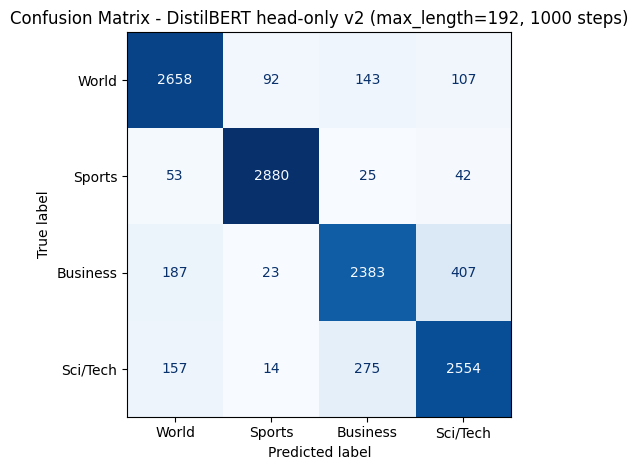

In [17]:
pred_out_v2 = trainer_v2.predict(enc_val_192)
logits_v2 = pred_out_v2.predictions
y_true_v2 = pred_out_v2.label_ids
y_pred_v2 = logits_v2.argmax(axis=-1)

labels4 = ["World","Sports","Business","Sci/Tech"]
cm_v2 = confusion_matrix(y_true_v2, y_pred_v2, labels=[0,1,2,3])

disp_v2 = ConfusionMatrixDisplay(cm_v2, display_labels=labels4)
plt.figure(figsize=(5.2, 4.4))
disp_v2.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix - DistilBERT head-only v2 (max_length=192, 1000 steps)")
plt.tight_layout()
plt.savefig("results/confmat_distilbert_head_v2_max192.png", dpi=300)
plt.show()
